In [1]:
import sys
import os
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(sys.path[0]))))

In [2]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'True'
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image,ImageDraw
import easyocr
import numpy as np
import json
import re
import torch
from tqdm import tqdm
from scripts.train.utils import smart_tokenizer_and_embedding_resize,Html2BboxTree,move_to_device,BboxTree2Html,add_special_tokens
from vars import *
from my_dataset import UICoderDataset,UICoderCollater
from transformers import AutoProcessor, Pix2StructForConditionalGeneration,AddedToken
from utils import Html2BboxTree, BboxTree2StyleList, BboxTree2Html
from datasets import Dataset

torch.manual_seed(SEED)

device = 'cuda:0'
model_path = "/data02/users/lz/code/UICoder/checkpoints/stage2/l256_p512_ws_1m*1/checkpoint-90000"
# data_path = '/data02/users/lz/code/UICoder/datasets/WebSight-format-parquet'
data_path = '/data02/starmage/datasets/cc/arrows_8-14_processed/'
output_dir = '/data02/users/lz/code/UICoder/test_result'

/data02/users/lz/miniconda3/envs/UICoder/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
processor = AutoProcessor.from_pretrained(processor_name_or_path)
model = Pix2StructForConditionalGeneration.from_pretrained(model_path,is_encoder_decoder=True,device_map=device,torch_dtype=torch.float16)
add_special_tokens(model, processor.tokenizer)

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


In [4]:
ds = Dataset.load_from_disk('/data02/users/lz/code/UICoder/datasets/WebSight-format-parquet/arrow')
# ds = UICoderDataset(path=data_path,processor=processor,max_length=2048,max_patches=512,max_num=100,drop_longer=True,stage=1,preprocess=True, make_patches_while_training=True, workers=1)

In [5]:
# image = Image.open('/data02/users/lz/code/image.jpg')
image = ds[669]['image']
image.size

(1280, 720)

In [6]:
def parse_prediction(prediction, size=(1280,960)):
    pieces = prediction.split('%')
    ftype = pieces[0].split('<')[0]
    fstyle = pieces[1]
    fnode = {
        'type': ftype,
        'style': fstyle
    }
    
    cnodes = list(filter(lambda x:x,pieces[0].split('<')[1].split('>')[0].split(')')))
    cnodes = list(map(lambda x:{
        'type': x.split('(')[0].replace(',',''),
        'bbox': list(map(lambda x:float(x),x.split('(')[1].split(',')))
    },cnodes))

    for idx, node in enumerate(cnodes):
        bbox = node['bbox']
        node['bbox'] =  [int(bbox[0]*size[0]), int(bbox[1]*size[1]), int(bbox[2]*size[0]), int(bbox[3]*size[1])]

    cstyles = ''.join(pieces[3:-1]).split(',')
    for idx, style in enumerate(cstyles[:len(cnodes)]):
        cnodes[idx]['style'] = style

    fnode['children'] = cnodes

    return fnode

def drawBboxOnImage(draw: ImageDraw,bbox_node):
    bbox = bbox_node['bbox']
    if bbox[2] > 0 and bbox[3] > 0:
        draw.rectangle((bbox[0],bbox[1],bbox[0]+bbox[2],bbox[1]+bbox[3]),outline="red",width=2)
    if 'children' in bbox_node:
        for node in bbox_node['children']:
            drawBboxOnImage(draw, node)

In [7]:
def predict(node, image):
    model.eval()
    with torch.no_grad():
        input = node['type']
        decoder_input_ids = processor.tokenizer.encode(input,return_tensors='pt',add_special_tokens=True)[...,:-1]
        encoding = processor(images=[image],text=[""],max_patches=512,return_tensors='pt')
        item = {
            'decoder_input_ids': decoder_input_ids,
            'flattened_patches': encoding['flattened_patches'].half(),
            'attention_mask': encoding['attention_mask']
        }
        item = move_to_device(item,device)

        outputs = model.generate(**item,max_new_tokens=2048,eos_token_id=processor.tokenizer.eos_token_id,do_sample=True)

        prediction = processor.tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

        pre_node = parse_prediction(prediction, (node['bbox'][2], node['bbox'][3]))

        node['children'] = pre_node['children']

In [10]:
root_node = {
    'type': 'body',
    'bbox': [0, 0, image.size[0], image.size[1]]
}
predict(root_node, image)

In [11]:
# for node in tqdm(root_node['children']):
#     try:
#         predict(node, image.crop((max(node['bbox'][0],0), max(node['bbox'][1],0), max(node['bbox'][0],0)+min(node['bbox'][2], image.size[0]), max(node['bbox'][1],0)+min(node['bbox'][3],image.size[1]))))
#     except:
#         print(1)
#         pass

In [12]:
root_node

{'type': 'body',
 'bbox': [0, 0, 1280, 720],
 'children': [{'type': 'header',
   'bbox': [0, 0, 1280, 86],
   'style': 'box-sizing: border-box; background-color: #f8f8f8; padding: 10px'},
  {'type': 'section',
   'bbox': [0, 86, 1280, 86],
   'style': 'box-sizing: border-box; border: 1px solid #000; padding: 10px'},
  {'type': 'section',
   'bbox': [0, 194, 1280, 57],
   'style': 'box-sizing: border-box; border: 1px solid #000; padding: 10px'},
  {'type': 'section',
   'bbox': [0, 237, 1280, 144],
   'style': 'box-sizing: border-box; display: flex; flex-wrap: wrap'}]}

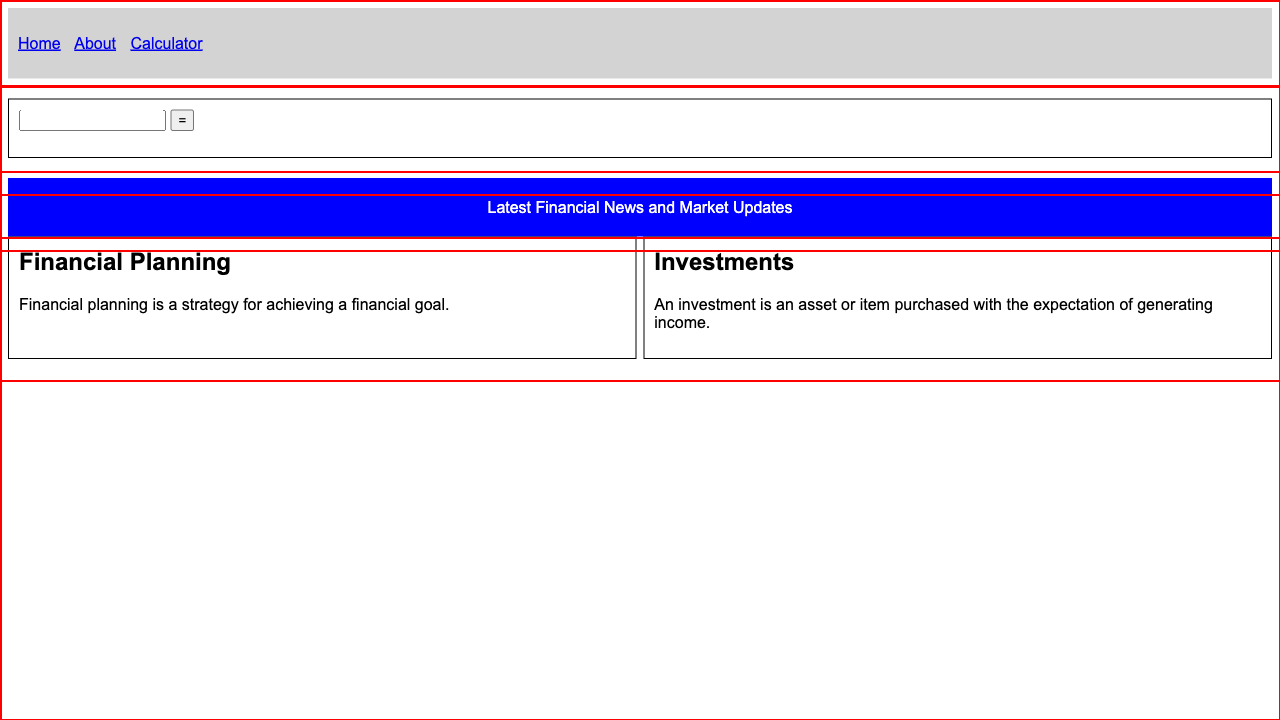

In [13]:
pImage = image.copy()
drawBboxOnImage(ImageDraw.Draw(pImage),root_node)
pImage